In [1]:
import os

# Change to the parent directory
os.chdir('../..')

# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [2]:
import deepSI
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.model_fitting import fit_and_plot_cycle
import src.plotting as ptt
from src.file_loader import load_csv_files
from src.model_fitting import fit_and_plot_cycle
from src.model import arx_model
import src.sysid_util as sid
import scipy as sp
import control as ct
import deepSI

c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# List of file names
file_names = [
    '9171_20240927_N11507060127_ Rapid polarization.csv',
    '9171_20240927_N11507060127_Rapid polarization-1.csv',
    '9171_20241001_N11507060127_ Rapid polarization-2.csv'
    ]

# print(f"Processing file: {file_names}")
dataframes = load_csv_files(file_names, '', 'deep learning assignment')


In [4]:
# Display the first 5 rows of each DataFrame
for key, df in dataframes.items():
    print(f"Head of DataFrame {key}:")
    print(df.head(5))
    print("\n")

Head of DataFrame 9171_20240927_N11507060127__Rapid_polarization_csv:
  Time (HH:mm:ss.SSS)    Channel   CH      V      A
0        11:51:33.361  0.9150142  CH1  1.415  0.046
1        11:51:33.597   1.151406  CH1  1.438  0.046
2        11:51:33.834  1.3879028  CH1   1.45  0.046
3        11:51:34.056  1.6098408  CH1  1.457  0.046
4        11:51:34.291  1.8455329  CH1  1.462  0.046


Head of DataFrame 9171_20240927_N11507060127_Rapid_polarization-1_csv:
  Time (HH:mm:ss.SSS)    Channel   CH      V      A
0        12:37:34.923  0.7860418  CH1   1.29  0.045
1        12:37:35.159  1.0221781  CH1  1.319  0.045
2        12:37:35.393  1.2562979  CH1  1.346  0.045
3        12:37:35.628  1.4910408  CH1  1.373  0.045
4        12:37:35.863  1.7256911  CH1    1.4  0.045


Head of DataFrame 9171_20241001_N11507060127__Rapid_polarization-2_csv:
  Time (HH:mm:ss.SSS)    Channel   CH      V      A
0        11:45:54.513   0.780562  CH1  1.429  0.046
1        11:45:54.753  1.0206133  CH1  1.444  0.046
2  


No missing values in 'Time (HH:mm:ss.SSS)' for 9171_20240927_N11507060127__Rapid_polarization_csv.

Number of missing values in 'V' for 9171_20240927_N11507060127__Rapid_polarization_csv: 27
Rows with missing values:

Number of missing values in 'A' for 9171_20240927_N11507060127__Rapid_polarization_csv: 27
Rows with missing values:

No missing values in 'Time (HH:mm:ss.SSS)' for 9171_20240927_N11507060127_Rapid_polarization-1_csv.

Number of missing values in 'V' for 9171_20240927_N11507060127_Rapid_polarization-1_csv: 51
Rows with missing values:

Number of missing values in 'A' for 9171_20240927_N11507060127_Rapid_polarization-1_csv: 51
Rows with missing values:

No missing values in 'Time (HH:mm:ss.SSS)' for 9171_20241001_N11507060127__Rapid_polarization-2_csv.

Number of missing values in 'V' for 9171_20241001_N11507060127__Rapid_polarization-2_csv: 63
Rows with missing values:

Number of missing values in 'A' for 9171_20241001_N11507060127__Rapid_polarization-2_csv: 63
Rows with

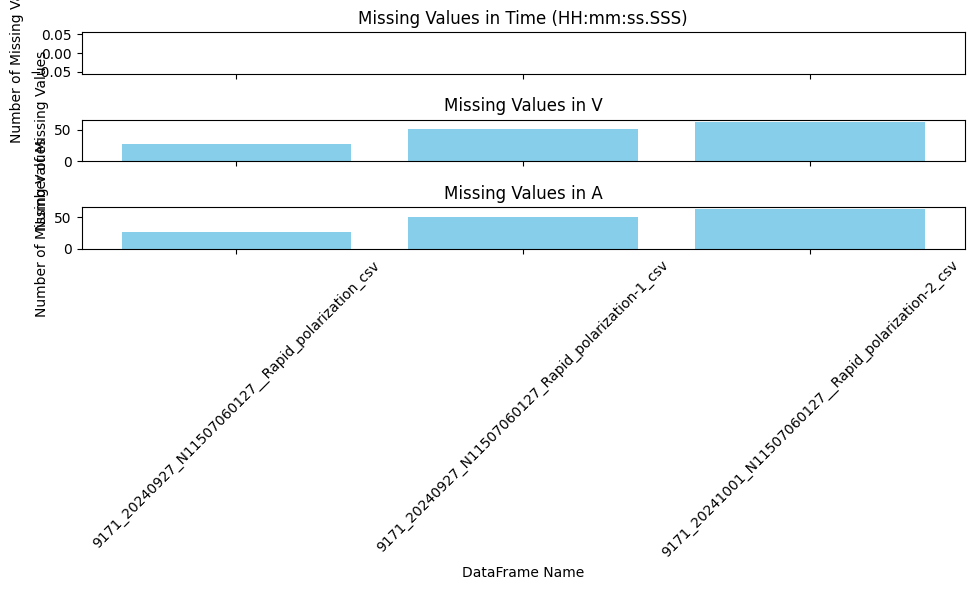

In [5]:
# Columns to check for missing values
COLUMNS_TO_CHECK = ['Time (HH:mm:ss.SSS)', 'V', 'A']

# Initialize a dictionary to store missing values count for each column in each DataFrame
missing_counts = {col: {} for col in COLUMNS_TO_CHECK}

for key, df in dataframes.items():
    # Check for missing values in each column
    for column in COLUMNS_TO_CHECK:
        missing_values = df[column].isna()
        num_missing = missing_values.sum()
        
        # Store the count of missing values for each column in the DataFrame
        missing_counts[column][key] = num_missing
        
        # Display rows with missing values (optional)
        if num_missing > 0:
            print(f"\nNumber of missing values in '{column}' for {key}: {num_missing}")
            print("Rows with missing values:")
        else:
            print(f"\nNo missing values in '{column}' for {key}.")

# Plot missing values count for each column in each DataFrame
fig, axes = plt.subplots(len(COLUMNS_TO_CHECK), 1, figsize=(10, 6), sharex=True)

for i, column in enumerate(COLUMNS_TO_CHECK):
    axes[i].bar(missing_counts[column].keys(), missing_counts[column].values(), color='skyblue')
    axes[i].set_ylabel('Number of Missing Values')
    axes[i].set_title(f'Missing Values in {column}')
    axes[i].tick_params(axis='x', rotation=45)

plt.xlabel('DataFrame Name')
plt.tight_layout()
plt.show()



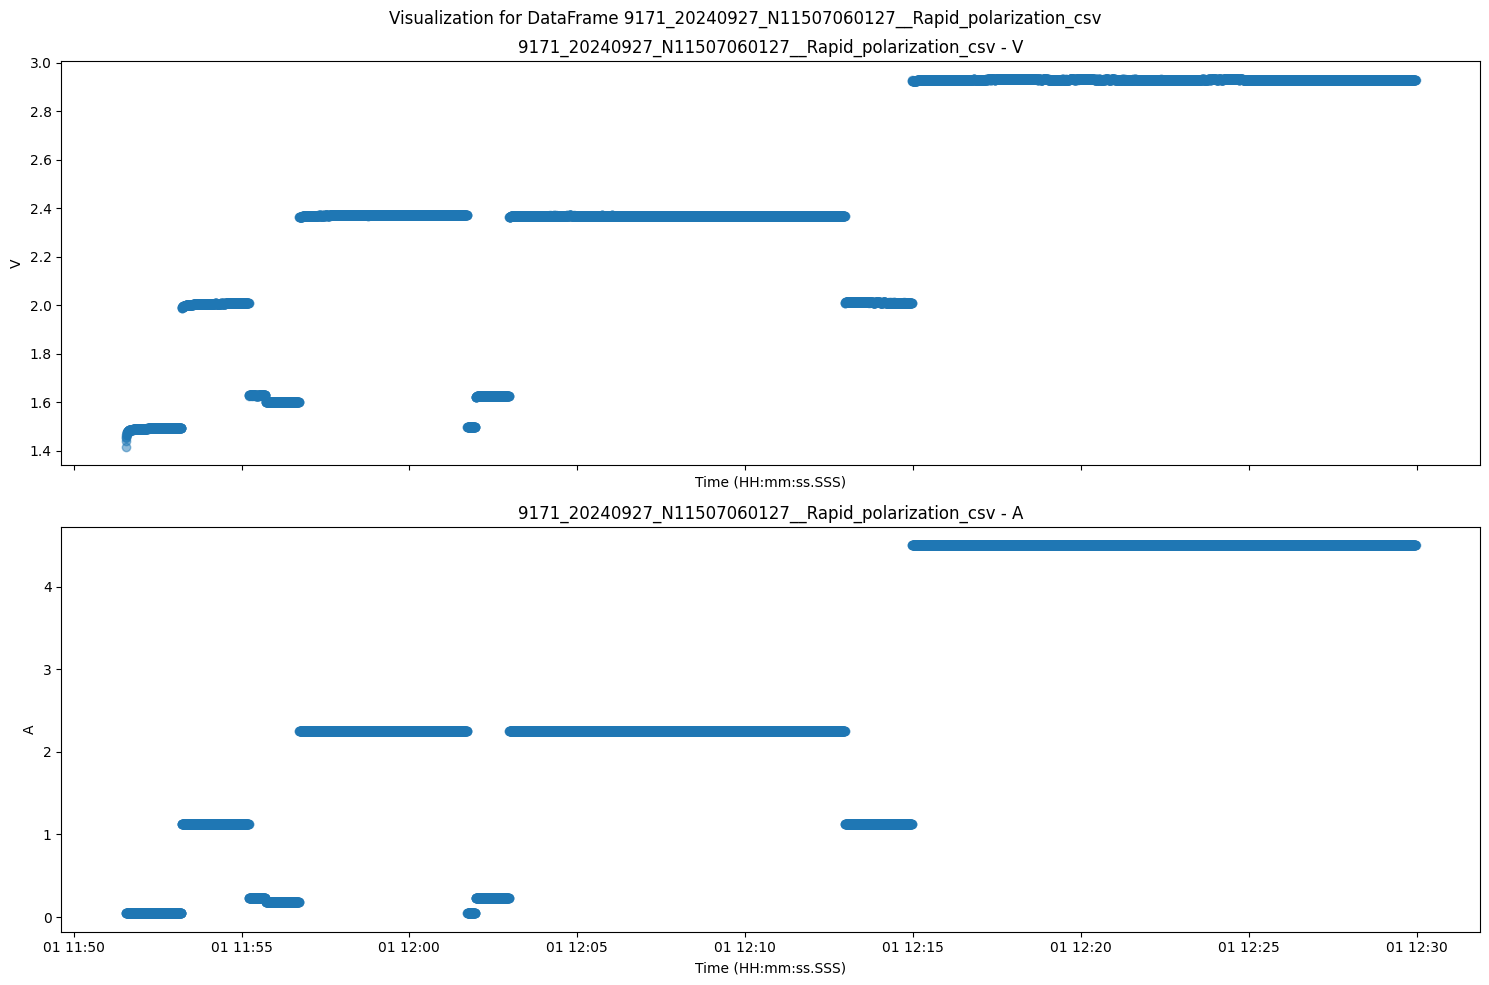

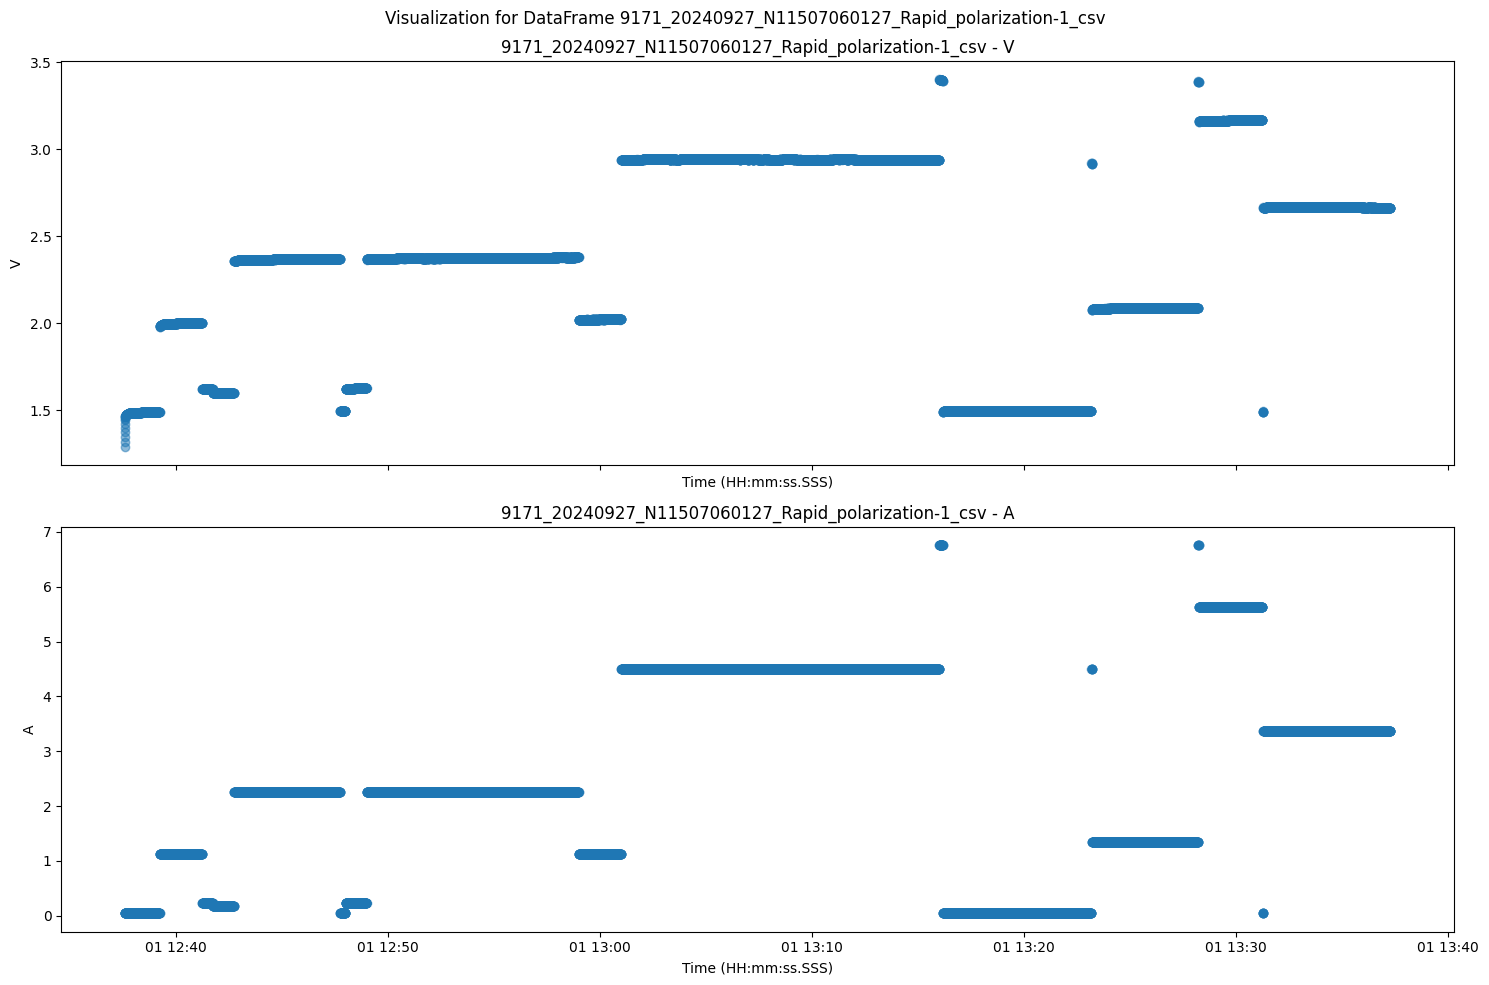

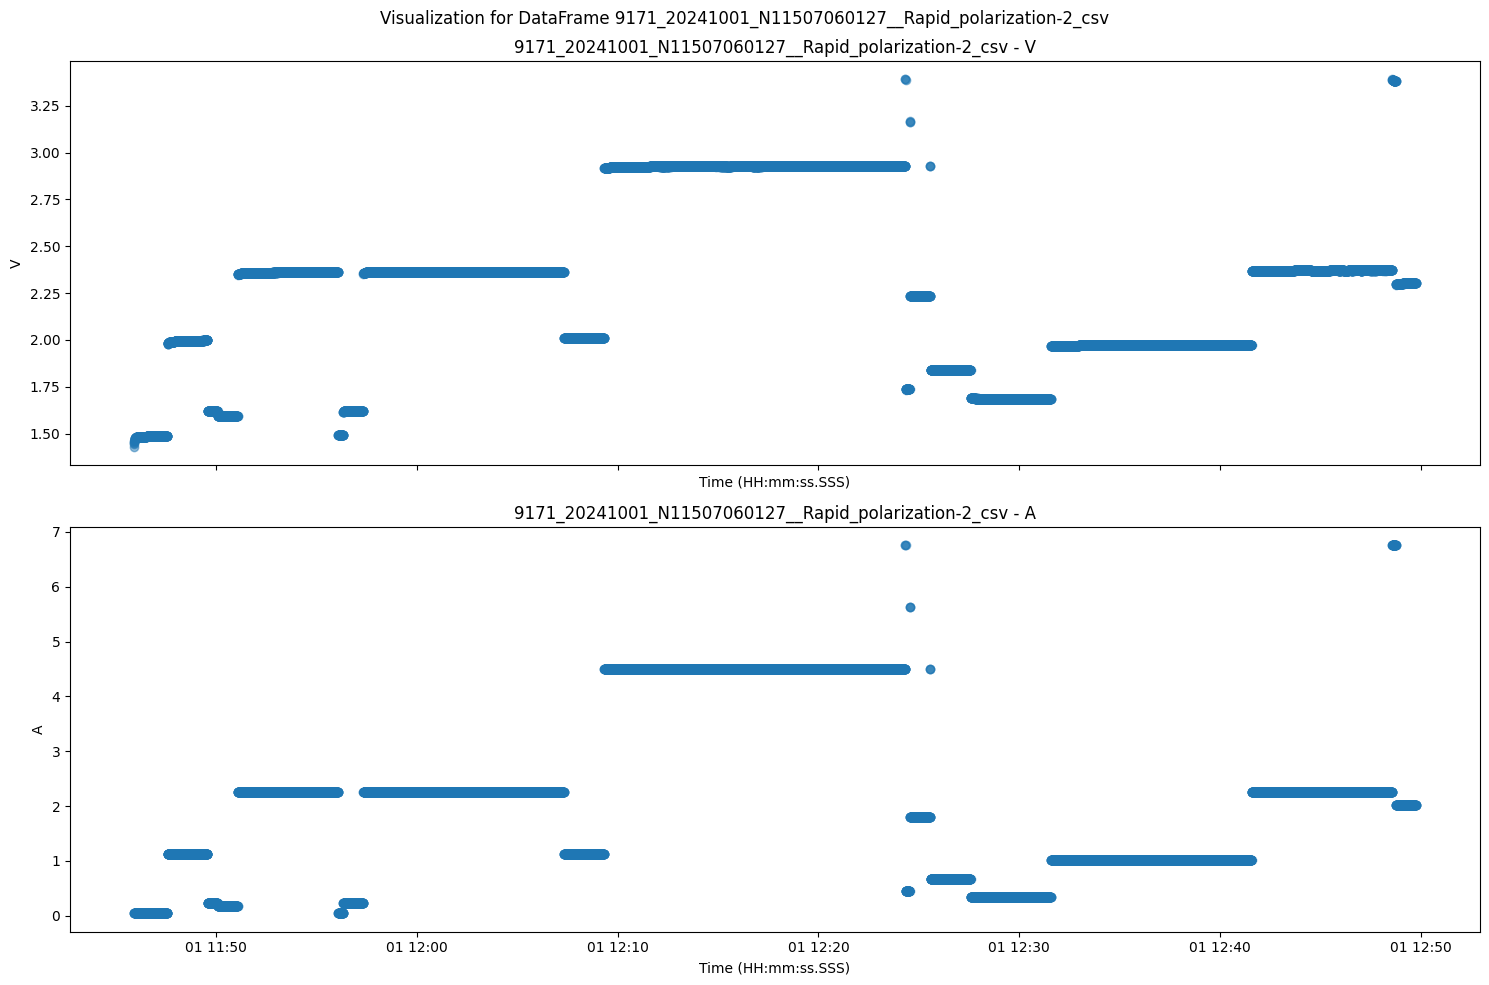

In [6]:
# Constants
TIME_COLUMN_NAME = 'Time (HH:mm:ss.SSS)'

# Create plots for each DataFrame
for key, df in dataframes.items():
    # Convert TIME_COLUMN_NAME to datetime with explicit format
    df[TIME_COLUMN_NAME] = pd.to_datetime(df[TIME_COLUMN_NAME], format='%H:%M:%S.%f', errors='coerce')
    
    # Ensure 'Channel', 'V', and 'A' are numeric
    df[['Channel', 'V', 'A']] = df[['Channel', 'V', 'A']].apply(pd.to_numeric, errors='coerce')
    
    # Plotting setup
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)
    fig.suptitle(f"Visualization for DataFrame {key}")
    
    # Scatter plots using plot_scatterplot_on_ax
    ptt.plot_scatterplot_on_ax(axs[0], df[TIME_COLUMN_NAME], df['V'], x_label=TIME_COLUMN_NAME, y_label='V', title=f"{key} - V")
    ptt.plot_scatterplot_on_ax(axs[1], df[TIME_COLUMN_NAME], df['A'], x_label=TIME_COLUMN_NAME, y_label='A', title=f"{key} - A")
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [7]:
# Assign specific dataframes as validation, test, and training
training_data = dataframes[list(dataframes.keys())[0]]  # First dataframe is validation # TRAINING
test_data = dataframes[list(dataframes.keys())[1]].iloc[9900:].reset_index(drop=True)       # Second dataframe is test # test after the outline after point 9000
validation_data = dataframes[list(dataframes.keys())[2]].iloc[9900:].reset_index(drop=True)   # Third dataframe is training # val after the outline after point 9000

print("Validation Data (df1):")
print(validation_data.shape)
print("\nTest Data (df2):")
print(test_data.shape)
print("\nTraining Data (df3):")
print(training_data.shape)

# Remove rows with any null values
validation_data = validation_data.dropna()
print("Rows with null values removed. New shape:", validation_data.shape)

test_data = test_data.dropna()
print("Rows with null values removed. New shape:", test_data.shape)

training_data = training_data.dropna()
print("Rows with null values removed. New shape:", training_data.shape)

Validation Data (df1):
(6483, 5)

Test Data (df2):
(5393, 5)

Training Data (df3):
(9831, 5)
Rows with null values removed. New shape: (6443, 5)
Rows with null values removed. New shape: (5369, 5)
Rows with null values removed. New shape: (9795, 5)


In [8]:
training_data.columns


Index(['Time (HH:mm:ss.SSS)', 'Channel', 'CH', 'V', 'A'], dtype='object')

In [9]:
# Extract input and output columns for each dataset
# For validation set
validation_x = validation_data['A'].values  # Input: Current (A)
validation_y = validation_data['V'].values  # Output: Voltage (V)

# For test set
test_x = test_data['A'].values  # Input: Current (A)
test_y = test_data['V'].values  # Output: Voltage (V)

# # For training set
# training_data['A'] = (training_data['A'] - training_data['A'].mean()) / training_data['A'].std()
# training_data['V'] = (training_data['V'] - training_data['V'].mean()) / training_data['V'].std()


train_x = training_data['A'].values  # Input: Current (A)
train_y = training_data['V'].values  # Output: Voltage (V)

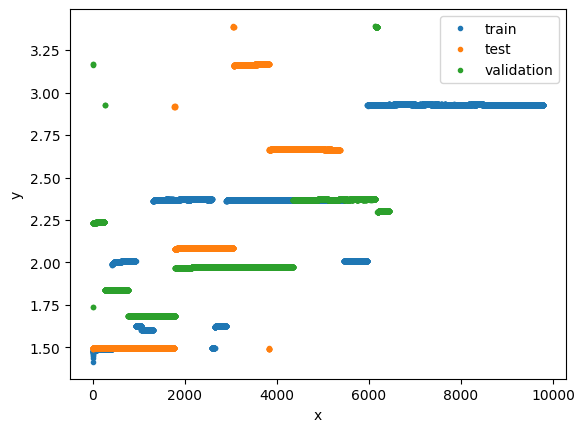

In [10]:
plt.plot(train_y, '.',label='train')  # Use extracted train_y
plt.plot(test_y, '.', label='test')    # Use extracted test_y
plt.plot(validation_y, '.', label='validation')  # Use extracted validation_y
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()


## Applying the deepSI NN

In [11]:
sys_data_train = deepSI.System_data(train_x, train_y)  # create a SystemData object
train = sys_data_train

sys_data_test = deepSI.System_data(test_x, test_y)  # create a SystemData object
test = sys_data_test

sys_data_val = deepSI.System_data(validation_x, validation_y)  # create a SystemData object
val = sys_data_val

In [12]:
sys_SS_linear = deepSI.fit_systems.Sklearn_io_linear(na=2,nb=5)
sys_SS_linear.fit(train)

# fit_sys_SS = deepSI.fit_systems.SS_linear(nx=3,feedthrough=False) #SS_f = 8
# fit_sys_IO = deepSI.fit_systems.Sklearn_io_linear(na=2,nb=2)

# fit_sys_SS.fit(train, SS_f = 8)
# print(f'SS \tA={fit_sys_SS.A} \n \t B={fit_sys_SS.B}\n\t C={fit_sys_SS.C}\n D={fit_sys_SS.D}') #parameters

# fit_sys_IO.fit(train)
# print(f'ARX paramters: [A,B] = {fit_sys_IO.reg.coef_} offset={fit_sys_IO.reg.intercept_}')  #parameters

0.34601484167770324
0.3264379215076788


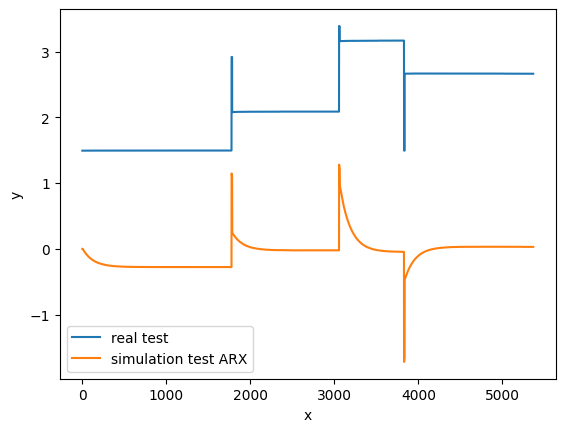

In [13]:
test_simulation_SS_linear = sys_SS_linear.apply_experiment(test)
train_simulation_SS_linear = sys_SS_linear.apply_experiment(train)
print(test_simulation_SS_linear.NRMS(test)) # 0.12984812533409787
print(train_simulation_SS_linear.NRMS(train)) # 0.13541408740489072
plt.plot(test.y)
plt.plot(test.y-test_simulation_SS_linear.y)
plt.ylabel('y'); plt.xlabel('x'); plt.legend(['real test','simulation test ARX'])
plt.show()

In [14]:
sys_encoder = deepSI.fit_systems.SS_encoder(nx=4, na=10, nb=10)
sys_encoder.fit(train_sys_data=train, val_sys_data=val, epochs=50, batch_size=256, loss_kwargs={'nf':50})
test_simulation_encoder = sys_encoder.apply_experiment(test)
train_simulation_encoder = sys_encoder.apply_experiment(train)
print(train_simulation_encoder.NRMS(train)) # 0.013109197256339526
print(test_simulation_encoder.NRMS(test)) # 0.01563269225510009

Initilizing the model and optimizer
Size of the training array =  8.9 MB
N_training_samples = 9736, batch_size = 256, N_batch_updates_per_epoch = 38
Initial Validation sim-NRMS= 1.2141071531323857


  2%|▏         | 40/1900 [00:07<09:18,  3.33it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.2839271926858815
It   38, sqrt loss  0.4099, Val sim-NRMS 0.2839, Time Loss: 82.5%, data: 1.1%, val: 16.4%,  5.6 batches/sec


  4%|▍         | 78/1900 [00:11<05:08,  5.91it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.13991774311572627
It   76, sqrt loss  0.1139, Val sim-NRMS 0.1399, Time Loss: 82.3%, data: 1.0%, val: 16.7%,  6.8 batches/sec


  6%|▌         | 115/1900 [00:15<06:00,  4.95it/s]

It  114, sqrt loss 0.05894, Val sim-NRMS 0.1499, Time Loss: 81.7%, data: 1.0%, val: 17.3%,  7.3 batches/sec


  8%|▊         | 154/1900 [00:20<06:02,  4.82it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.1364946422957333
It  152, sqrt loss 0.05261, Val sim-NRMS 0.1365, Time Loss: 81.7%, data: 1.0%, val: 17.3%,  7.5 batches/sec


 10%|█         | 191/1900 [00:25<07:32,  3.78it/s]

It  190, sqrt loss 0.05053, Val sim-NRMS 0.1389, Time Loss: 82.5%, data: 1.0%, val: 16.5%,  7.4 batches/sec


 12%|█▏        | 228/1900 [00:31<13:30,  2.06it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.13019987147524353
It  228, sqrt loss 0.04929, Val sim-NRMS 0.1302, Time Loss: 81.8%, data: 1.0%, val: 17.2%,  7.2 batches/sec


 14%|█▍        | 267/1900 [00:38<08:26,  3.23it/s]

It  266, sqrt loss 0.04862, Val sim-NRMS 0.1349, Time Loss: 82.1%, data: 1.0%, val: 16.9%,  7.0 batches/sec


 16%|█▌        | 305/1900 [00:44<09:26,  2.82it/s]

It  304, sqrt loss 0.04855, Val sim-NRMS 0.1306, Time Loss: 82.0%, data: 1.0%, val: 17.0%,  6.9 batches/sec


 18%|█▊        | 343/1900 [00:50<08:37,  3.01it/s]

It  342, sqrt loss 0.04785, Val sim-NRMS 0.1378, Time Loss: 82.0%, data: 1.0%, val: 16.9%,  6.8 batches/sec


 20%|██        | 381/1900 [00:56<08:40,  2.92it/s]

It  380, sqrt loss 0.04731, Val sim-NRMS 0.1345, Time Loss: 82.2%, data: 1.0%, val: 16.7%,  6.7 batches/sec


 22%|██▏       | 419/1900 [01:02<08:38,  2.86it/s]

It  418, sqrt loss 0.04709, Val sim-NRMS 0.1397, Time Loss: 82.2%, data: 1.0%, val: 16.8%,  6.7 batches/sec


 24%|██▍       | 457/1900 [01:08<08:28,  2.84it/s]

It  456, sqrt loss 0.04707, Val sim-NRMS 0.1472, Time Loss: 82.1%, data: 1.0%, val: 16.8%,  6.6 batches/sec


 26%|██▌       | 495/1900 [01:15<07:38,  3.06it/s]

It  494, sqrt loss 0.04685, Val sim-NRMS 0.1464, Time Loss: 82.2%, data: 1.0%, val: 16.8%,  6.6 batches/sec


 28%|██▊       | 533/1900 [01:20<07:47,  2.92it/s]

It  532, sqrt loss 0.04697, Val sim-NRMS 0.1416, Time Loss: 82.1%, data: 1.0%, val: 16.9%,  6.6 batches/sec


 30%|███       | 571/1900 [01:26<07:51,  2.82it/s]

It  570, sqrt loss 0.04626, Val sim-NRMS 0.1459, Time Loss: 82.0%, data: 1.0%, val: 17.0%,  6.6 batches/sec


 32%|███▏      | 609/1900 [01:32<07:11,  2.99it/s]

It  608, sqrt loss 0.04587, Val sim-NRMS 0.1401, Time Loss: 81.9%, data: 1.0%, val: 17.0%,  6.6 batches/sec


 34%|███▍      | 647/1900 [01:38<06:52,  3.03it/s]

It  646, sqrt loss 0.04626, Val sim-NRMS 0.1422, Time Loss: 81.9%, data: 1.1%, val: 17.0%,  6.6 batches/sec


 36%|███▌      | 686/1900 [01:44<05:12,  3.88it/s]

It  684, sqrt loss 0.04562, Val sim-NRMS 0.1412, Time Loss: 81.9%, data: 1.1%, val: 17.0%,  6.6 batches/sec


 38%|███▊      | 723/1900 [01:50<06:37,  2.96it/s]

It  722, sqrt loss 0.04559, Val sim-NRMS 0.1442, Time Loss: 81.8%, data: 1.1%, val: 17.1%,  6.6 batches/sec


 40%|████      | 761/1900 [01:55<05:48,  3.26it/s]

It  760, sqrt loss 0.04536, Val sim-NRMS 0.1421, Time Loss: 81.9%, data: 1.1%, val: 17.0%,  6.6 batches/sec


 42%|████▏     | 799/1900 [02:01<06:13,  2.95it/s]

It  798, sqrt loss 0.04545, Val sim-NRMS 0.1448, Time Loss: 81.9%, data: 1.1%, val: 17.1%,  6.6 batches/sec


 44%|████▍     | 837/1900 [02:07<06:21,  2.79it/s]

It  836, sqrt loss 0.04517, Val sim-NRMS 0.1407, Time Loss: 81.8%, data: 1.1%, val: 17.1%,  6.6 batches/sec


 46%|████▌     | 875/1900 [02:12<05:33,  3.07it/s]

It  874, sqrt loss 0.04544, Val sim-NRMS 0.1467, Time Loss: 81.8%, data: 1.1%, val: 17.1%,  6.6 batches/sec


 48%|████▊     | 913/1900 [02:18<05:06,  3.22it/s]

It  912, sqrt loss 0.04578, Val sim-NRMS 0.1496, Time Loss: 81.8%, data: 1.1%, val: 17.1%,  6.6 batches/sec


 50%|█████     | 951/1900 [02:23<05:07,  3.09it/s]

It  950, sqrt loss 0.04518, Val sim-NRMS 0.1416, Time Loss: 81.8%, data: 1.1%, val: 17.1%,  6.6 batches/sec


 52%|█████▏    | 989/1900 [02:29<04:40,  3.25it/s]

It  988, sqrt loss 0.04513, Val sim-NRMS 0.1477, Time Loss: 81.8%, data: 1.1%, val: 17.1%,  6.6 batches/sec


 54%|█████▍    | 1026/1900 [02:34<05:35,  2.61it/s]

It 1026, sqrt loss 0.04471, Val sim-NRMS 0.1458, Time Loss: 81.8%, data: 1.1%, val: 17.1%,  6.6 batches/sec


 56%|█████▌    | 1065/1900 [02:40<04:19,  3.22it/s]

It 1064, sqrt loss 0.04457, Val sim-NRMS  0.152, Time Loss: 81.9%, data: 1.1%, val: 17.0%,  6.6 batches/sec


 58%|█████▊    | 1102/1900 [02:47<06:43,  1.98it/s]

It 1102, sqrt loss 0.04449, Val sim-NRMS 0.1432, Time Loss: 81.8%, data: 1.1%, val: 17.1%,  6.6 batches/sec


 60%|██████    | 1141/1900 [02:54<04:43,  2.68it/s]

It 1140, sqrt loss  0.0443, Val sim-NRMS 0.1465, Time Loss: 81.9%, data: 1.1%, val: 17.0%,  6.5 batches/sec


 62%|██████▏   | 1179/1900 [03:00<03:26,  3.49it/s]

It 1178, sqrt loss 0.04443, Val sim-NRMS 0.1482, Time Loss: 81.7%, data: 1.1%, val: 17.2%,  6.5 batches/sec


 64%|██████▍   | 1217/1900 [03:06<03:44,  3.04it/s]

It 1216, sqrt loss 0.04488, Val sim-NRMS 0.1542, Time Loss: 81.8%, data: 1.1%, val: 17.1%,  6.5 batches/sec


 66%|██████▌   | 1255/1900 [03:12<03:16,  3.28it/s]

It 1254, sqrt loss 0.04409, Val sim-NRMS 0.1478, Time Loss: 81.7%, data: 1.1%, val: 17.2%,  6.5 batches/sec


 68%|██████▊   | 1293/1900 [03:18<04:45,  2.13it/s]

It 1292, sqrt loss 0.04502, Val sim-NRMS 0.1499, Time Loss: 81.6%, data: 1.1%, val: 17.3%,  6.5 batches/sec


 70%|███████   | 1331/1900 [03:27<06:10,  1.54it/s]

It 1330, sqrt loss 0.04386, Val sim-NRMS 0.1547, Time Loss: 81.1%, data: 1.1%, val: 17.8%,  6.4 batches/sec


 72%|███████▏  | 1368/1900 [03:33<02:20,  3.79it/s]

It 1368, sqrt loss 0.04438, Val sim-NRMS 0.1468, Time Loss: 81.2%, data: 1.1%, val: 17.7%,  6.4 batches/sec


 74%|███████▍  | 1408/1900 [03:39<01:23,  5.91it/s]

It 1406, sqrt loss  0.0435, Val sim-NRMS 0.1499, Time Loss: 81.3%, data: 1.1%, val: 17.6%,  6.4 batches/sec


 76%|███████▌  | 1446/1900 [03:43<01:15,  6.01it/s]

It 1444, sqrt loss 0.04412, Val sim-NRMS 0.1492, Time Loss: 81.3%, data: 1.1%, val: 17.6%,  6.5 batches/sec


 78%|███████▊  | 1483/1900 [03:48<01:30,  4.61it/s]

It 1482, sqrt loss 0.04358, Val sim-NRMS 0.1477, Time Loss: 81.3%, data: 1.1%, val: 17.6%,  6.5 batches/sec


 80%|████████  | 1522/1900 [03:52<01:01,  6.19it/s]

It 1520, sqrt loss 0.04302, Val sim-NRMS 0.1474, Time Loss: 81.3%, data: 1.1%, val: 17.6%,  6.5 batches/sec


 82%|████████▏ | 1559/1900 [03:56<01:00,  5.61it/s]

It 1558, sqrt loss 0.04269, Val sim-NRMS 0.1479, Time Loss: 81.3%, data: 1.1%, val: 17.6%,  6.6 batches/sec


 84%|████████▍ | 1598/1900 [04:01<00:47,  6.36it/s]

It 1596, sqrt loss 0.04301, Val sim-NRMS  0.143, Time Loss: 81.3%, data: 1.1%, val: 17.6%,  6.6 batches/sec


 86%|████████▌ | 1635/1900 [04:07<02:04,  2.13it/s]

It 1634, sqrt loss 0.04245, Val sim-NRMS 0.1407, Time Loss: 80.8%, data: 1.1%, val: 18.1%,  6.6 batches/sec


 88%|████████▊ | 1672/1900 [04:17<04:16,  1.13s/it]

It 1672, sqrt loss 0.04247, Val sim-NRMS 0.1403, Time Loss: 80.5%, data: 1.1%, val: 18.4%,  6.5 batches/sec


 90%|█████████ | 1711/1900 [04:30<01:47,  1.77it/s]

It 1710, sqrt loss 0.04253, Val sim-NRMS 0.1377, Time Loss: 80.6%, data: 1.1%, val: 18.3%,  6.3 batches/sec


 92%|█████████▏| 1750/1900 [04:39<00:48,  3.12it/s]

It 1748, sqrt loss 0.04255, Val sim-NRMS 0.1376, Time Loss: 80.8%, data: 1.1%, val: 18.1%,  6.3 batches/sec


 94%|█████████▍| 1787/1900 [04:44<00:32,  3.51it/s]

It 1786, sqrt loss 0.04291, Val sim-NRMS 0.1348, Time Loss: 80.8%, data: 1.1%, val: 18.1%,  6.3 batches/sec


 96%|█████████▌| 1826/1900 [04:49<00:16,  4.41it/s]

It 1824, sqrt loss 0.04176, Val sim-NRMS 0.1351, Time Loss: 80.8%, data: 1.1%, val: 18.1%,  6.3 batches/sec


 98%|█████████▊| 1863/1900 [04:56<00:15,  2.43it/s]

It 1862, sqrt loss 0.04197, Val sim-NRMS  0.137, Time Loss: 80.8%, data: 1.1%, val: 18.1%,  6.3 batches/sec


100%|██████████| 1900/1900 [05:02<00:00,  6.28it/s]

It 1900, sqrt loss 0.04179, Val sim-NRMS 0.1355, Time Loss: 80.7%, data: 1.1%, val: 18.2%,  6.3 batches/sec
Loaded model with best known validation sim-NRMS of 0.1302 which happened on epoch 228 (epoch_id=6.00)



c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\deepSI\fit_systems\fit_system.py:501: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

0.04808614769727727
0.1378386287658625


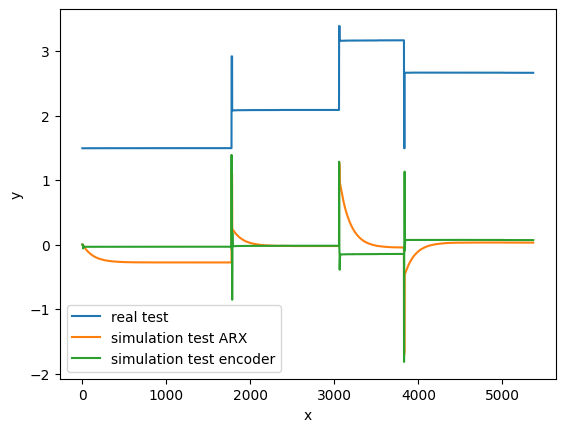

In [15]:
plt.plot(test.y)
plt.plot(test.y-test_simulation_SS_linear.y)
plt.plot(test.y-test_simulation_encoder.y)
plt.ylabel('y'); plt.xlabel('x'); plt.legend(['real test','simulation test ARX', 'simulation test encoder'])
plt.show()

## Exploring other Models

Epoch 1/50


c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0540 - mae: 0.1317 - val_loss: 2.7339 - val_mae: 1.6498
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mae: 0.0315 - val_loss: 2.7191 - val_mae: 1.6456
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010 - mae: 0.0263 - val_loss: 2.7266 - val_mae: 1.6488
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0347e-04 - mae: 0.0070 - val_loss: 2.6926 - val_mae: 1.6386
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3020e-05 - mae: 0.0024 - val_loss: 2.6816 - val_mae: 1.6351
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1309e-05 - mae: 0.0018 - val_loss: 2.6774 - val_mae: 1.6337
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8406e-06 - mae: 0.0013 - val_loss: 2.6724 - val_mae: 1.6321
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0000e-06 - mae: 0.0011 - val_loss: 2.6739 - val_mae: 1.6325
Epoch 9/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

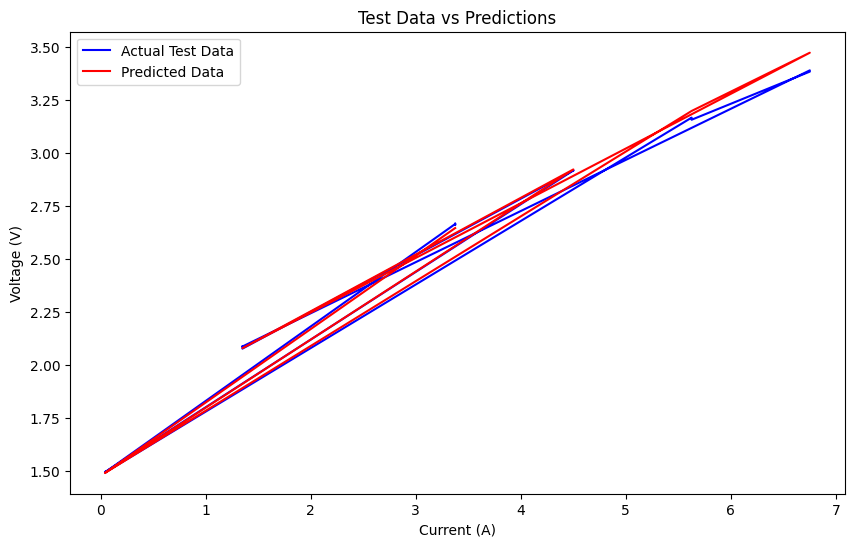

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7825e-05 - mae: 0.0043
Test Loss (MSE): 0.00012711255112662911
Test MAE: 0.008646687492728233


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# --- Data Preprocessing ---
# Reshape the data for scalers (expected 2D input)
train_x = train_x.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)
test_x = test_x.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)
validation_x = validation_x.reshape(-1, 1)
validation_y = validation_y.reshape(-1, 1)

# Scale the data using MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

train_x_scaled = scaler_x.fit_transform(train_x)
train_y_scaled = scaler_y.fit_transform(train_y)
test_x_scaled = scaler_x.transform(test_x)
validation_x_scaled = scaler_x.transform(validation_x)

# --- Neural Network Model ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),  # Input layer
    Dense(32, activation='relu'),                   # Hidden layer
    Dense(1)                                        # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    train_x_scaled, train_y_scaled,
    epochs=50, batch_size=32, verbose=1,
    validation_data=(validation_x_scaled, validation_y)
)

# --- Predictions ---
# Predict on the test set
predictions_scaled = model.predict(test_x_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

# --- Plot Results ---
plt.figure(figsize=(10, 6))
plt.plot(test_x, test_y, label='Actual Test Data', color='blue')
plt.plot(test_x, predictions, label='Predicted Data', color='red')
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.title('Test Data vs Predictions')
plt.legend()
plt.show()

# --- Evaluate Model ---
test_loss, test_mae = model.evaluate(test_x_scaled, scaler_y.transform(test_y), verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")


In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Select scaler: Min-Max Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Normalize training, validation, and test data
train_x = scaler_x.fit_transform(train_x.reshape(-1, 1))
train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
validation_x = scaler_x.transform(validation_x.reshape(-1, 1))
validation_y = scaler_y.transform(validation_y.reshape(-1, 1))
test_x = scaler_x.transform(test_x.reshape(-1, 1))
test_y = scaler_y.transform(test_y.reshape(-1, 1))


In [18]:
import numpy as np

def create_sliding_window(data_x, data_y, window_size):
    x, y = [], []
    for i in range(len(data_x) - window_size):
        x.append(data_x[i:i + window_size])
        y.append(data_y[i + window_size])
    return np.array(x), np.array(y)

window_size = 10
train_x_seq, train_y_seq = create_sliding_window(train_x, train_y, window_size)
validation_x_seq, validation_y_seq = create_sliding_window(validation_x, validation_y, window_size)
test_x_seq, test_y_seq = create_sliding_window(test_x, test_y, window_size)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, 1)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    train_x_seq, train_y_seq,
    validation_data=(validation_x_seq, validation_y_seq),
    epochs=50,
    batch_size=32
)


Epoch 1/50


c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0793 - mae: 0.1426 - val_loss: 0.0011 - val_mae: 0.0178
Epoch 2/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.9451e-04 - mae: 0.0062 - val_loss: 8.0108e-04 - val_mae: 0.0065
Epoch 3/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.7188e-04 - mae: 0.0049 - val_loss: 9.4036e-04 - val_mae: 0.0143
Epoch 4/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.9135e-04 - mae: 0.0061 - val_loss: 7.5548e-04 - val_mae: 0.0101
Epoch 5/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.6980e-04 - mae: 0.0071 - val_loss: 6.4894e-04 - val_mae: 0.0074
Epoch 6/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.5085e-04 - mae: 0.0061 - val_loss: 5.9224e-04 - val_mae: 0.0064
Epoch 7/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.7716e-04 - mae: 0.0079 - val_loss: 6.0395e-04 - val_mae: 0.0089
Epoch 8/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.0481e-04 - mae: 0.0064 - val_loss: 5.9979e-04 - val_mae: 0.0112
Epoch 9/50


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test data
predictions = model.predict(test_x_seq)

# Rescale predictions back to the original scale
predictions_rescaled = scaler_y.inverse_transform(predictions)
test_y_rescaled = scaler_y.inverse_transform(test_y_seq)

# Compute evaluation metrics
mse = mean_squared_error(test_y_rescaled, predictions_rescaled)
mae = mean_absolute_error(test_y_rescaled, predictions_rescaled)
r2 = r2_score(test_y_rescaled, predictions_rescaled)

print(f"MSE: {mse}, MAE: {mae}, R²: {r2}")


168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MSE: 0.0018755749046644888, MAE: 0.012431843292092584, R²: 0.9948587083137719


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


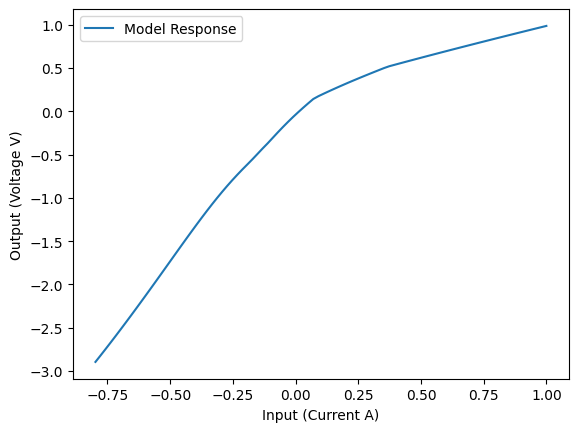

In [21]:
import matplotlib.pyplot as plt

# Simulate response to varying inputs
test_input = np.linspace(-1, 1, 100).reshape(-1, 1)  # Example input pattern
test_input_seq, _ = create_sliding_window(test_input, test_input, window_size)
response = model.predict(test_input_seq)

# Plot the response
plt.plot(test_input[window_size:], response, label='Model Response')
plt.xlabel('Input (Current A)')
plt.ylabel('Output (Voltage V)')
plt.legend()
plt.show()
